In [1]:
%load_ext Cython
%load_ext line_profiler

In [2]:
%%cython
import os
import sys
import tensorflow as tf
import itertools
import numpy as np
import numba as nb
from math import sqrt, log
from numpy import unravel_index
from random import choice, random, sample
from operator import itemgetter
np.random.seed(1337)  # for reproducibility
from keras.models import Sequential, Model, load_model
from keras.layers import Input, BatchNormalization, Reshape
from keras.layers import Dense, Dropout, Activation, Flatten, LocallyConnected2D
from keras.layers import Conv2D, MaxPooling2D, AlphaDropout, ConvLSTM2D, AvgPool2D, Conv2DTranspose, UpSampling2D
from keras.layers import add, concatenate, multiply
from keras.initializers import VarianceScaling, RandomUniform
from keras.optimizers import Adam, SGD, rmsprop
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils, multi_gpu_model
from keras.utils.vis_utils import plot_model
from keras.engine.topology import Container
from keras.optimizers import SGD, Adadelta, Adagrad
from keras.regularizers import l1, l2
import keras.backend as K
K.set_image_dim_ordering('th')

from keras.callbacks import Callback, ReduceLROnPlateau, LearningRateScheduler, TensorBoard, ModelCheckpoint
import matplotlib.pyplot as plt
import time
#%matplotlib notebook

Using TensorFlow backend.


In [4]:
%%cython
import numpy as np
cimport numpy as np
import matplotlib.pyplot as plt

cdef class Ataxx:
    cdef public np.int8_t[:, :] data

    def __init__(self, board=None):
        if board is None:                  # if there is no initialization given
            self.data = np.zeros((7, 7), dtype=np.int8)   # then generate a board with starting init, and black(-1) takes first turn
            self.data[0, 0] = -1           
            self.data[6, 6] = -1
            self.data[0, 6] = 1
            self.data[6, 0] = 1
        else:
            self.data = board.copy()
        
    def get_feature_map(self, turn):
        out = np.zeros((3, 9, 9))
        # define 1 edge
        out[0][:, :] = np.ones((9, 9), np.int8)
        out[0][1:-1, 1:-1] = np.zeros((7, 7), np.int8)
        # define friendly map
        out[1][1:-1, 1:-1] = (np.array(self.data) == turn).astype(np.int8)
        out[2][1:-1, 1:-1] = (np.array(self.data) == -turn).astype(np.int8)
        
        return out
    
    def plot(self, is_next_move=False, turn=None):                        # plot the board
        image = self.data.copy()
        if is_next_move:
            if turn not in [-1, 1]:
                raise ValueError("Turn must be -1 or 1, or Must input a turn for next moves")
            else:
                next_moves = self.get_moves(turn)
                if len(next_moves) == 0:
                    raise ValueError("Game is over already")
                next_pos = list(zip(*next_moves))[1]
                for pos in next_pos:
                    image[pos] = turn / 2
        plt.imshow(image, cmap='gray')
        plt.xticks(range(7), range(7))
        plt.yticks(range(7), range(7))
        plt.show()
                
    def is_valid(self, turn, pos):
        cdef int dr, dc, r = pos[0], c = pos[1], new_r, new_c
        if self.data[r, c] != 0:
            return False
        else:
            for dr in range(-2, 3):
                for dc in range(-2, 3):
                    new_r = r+dr
                    new_c = c+dc
                    if new_r >= 0 and new_c >= 0 and new_r < 7 and new_c < 7 and self.data[new_r, new_c] == turn:
                        return True
            return False 
        
    def get_moves(self, turn):
        cdef int r, c, dr, dc, new_r, new_c
        next_moves = []
        buffer_moves = []
        for r in range(7):
            for c in range(7):
                if self.is_valid(turn, (r, c)): # duplicate move
                    has_duplicate_move = False
                    for dr in range(-2, 3):
                        for dc in range(-2, 3):
                            new_r = r+dr
                            new_c = c+dc
                            if new_r >= 0 and new_c >= 0 and new_r < 7 and new_c < 7 \
                                and self.data[new_r, new_c] == turn\
                                and not has_duplicate_move:
                                if abs(dr) <= 1 and abs(dc) <=1:
                                    buffer_moves = [((new_r, new_c), (r, c))]
                                    has_duplicate_move = True
                                elif self.data[new_r, new_c] == turn:
                                    buffer_moves.append(((new_r, new_c), (r, c)))
                                else:
                                    continue
                            if has_duplicate_move:
                                break
                        if has_duplicate_move:
                            break
                    next_moves.extend(buffer_moves)
        return next_moves
    
    def get_greedy_move(self, turn):
        moves = self.get_moves(turn)
        if len(moves) == 0:
            raise ValueError('No Possible Moves')
        store_data = self.data.copy()
        best_score = -1000000
        for move in moves:
            self.data = store_data.copy()
            self.move_to(turn, move[0], move[1])
            score = self.evaluate(turn, -turn)
            if score > best_score:
                best_move = move
                best_score = score
        self.data = store_data
        return best_move
        
    def move_to(self, turn, pos0, pos1):
        cdef int dr, dc, x0 = pos0[0], y0 = pos0[1], x1 = pos1[0], y1 = pos1[1]
        
        if not self.is_valid(turn, pos1):
            raise ValueError("This move: " + str((pos0, pos1)) + " of turn: " + str(turn) + " is invalid") 
        elif self.data[x0, y0] != turn:
            raise ValueError("The starting position is not your piece")
        else:
            self.data[x1, y1] = turn
            if abs(x0 - x1) > 1 or abs(y0 - y1) > 1:   # jump move
                self.data[x0, y0] = 0

            for dr in range(-1, 2):                  # infection mode!!!!
                for dc in range(-1, 2):
                    if x1+dr >= 0 and y1+dc >= 0 and x1+dr < 7 and y1+dc < 7:
                        if self.data[x1+dr, y1+dc] == -turn:  # convert any piece of the opponent to 'turn'
                            self.data[x1+dr, y1+dc] = turn
    
    def evaluate(self, turn, this_turn, max_score=1, min_score=0):
        cdef int r, c, turn_no=0, op_no=0
        if turn not in [-1, 1]:
            raise ValueError("Turn must be -1 or 1") 
        else:
            for r in range(7):
                for c in range(7):
                    if self.data[r, c] == turn:
                        turn_no += 1
                    elif self.data[r, c] == -turn:
                        op_no += 1

            if len(self.get_moves(this_turn)) == 0:# if one of them can no longer move, count and end
                if turn_no > op_no:
                    return max_score
                else:
                    return -max_score
            else:
                value = turn_no - op_no
            return value * min_score

In [5]:
@nb.jit(nopython=True)
def for_none(c, parent_n_visit):
    return np.random.random()*1e-4 + c * sqrt(2 * log(parent_n_visit+1))

@nb.jit(nopython=True)
def for_node(c, parent_n_visit, n_visit, n_win):
    return (n_win) / (n_visit)\
                    + c * sqrt(2 * log(parent_n_visit+1) / (n_visit+1))\
                    + np.random.random()*1e-4
        
class TreeNode():
    def __init__(self, parent):
        self._parent = parent
        self._children = {} # a dictionary of action:node
        self._n_visit = 0.0
        self._n_win = 0.0 # the win here is from the parent perspective
    
    def update_all(self, is_win):
        node = self
        while not node is None:
            is_win = not is_win # intended
            node._n_win += is_win
            node._n_visit += 1
            node = node._parent
            
    @staticmethod
    def get_search_value(parent, node, c):
        if node is None:
            # log and sqrt in math module is super fast
            value = for_none(c, parent._n_visit)
        else:
            value = for_node(c, parent._n_visit, node._n_visit, node._n_win)
        return value
        
    @staticmethod
    def get_frequency_value(node):
        if node is None:
            return 0
        else:
            return node._n_visit
    
    def select(self, c):
        best_node = max(self._children.items(), key=lambda node: self.get_search_value(self, node[1], c))
        if best_node[1] is None:
            new_node = TreeNode(self)
            self._children[best_node[0]] = new_node
            return (best_node[0], new_node)
        else:
            return best_node
        
    def get_action_mask(self):
        out = np.zeros((7, 7))
        for action in self._children:
            out[action[1]] = 1
        return out
    
    def get_action_frequency_map(self):
        n_visit = self._n_visit
        global policy_dict
        out = np.zeros(len(policy_dict))
        for node in self._children.items():
            out[policy_dict[node[0]]] = node[1]._n_visit / n_visit
        return out

In [6]:
class MCTS():
    def __init__(self, c=2):
        self._root = TreeNode(None)
        self._c = c
        self._game = Ataxx()
        self._turn = -1
        
    def expand(self, node, game, turn):
        new_moves = game.get_moves(turn)
        for move in new_moves:
            node._children[move] = None # do not create a node until it is explored
    
    def rollout(self, rollout_times=100):
        for i in range(rollout_times):
            tmp_node = self._root
            tmp_game = Ataxx(self._game.data)
            tmp_turn = self._turn
            # step counter init
            step = 0
            while True:
                # expand tree
                if tmp_node._children == {}:
                    self.expand(tmp_node, tmp_game, tmp_turn)
                # check if is leaf node, if so, update the whole tree
                if tmp_node._children == {}:
                    turn_no = 0
                    op_no = 0
                    for r in range(7):
                        for c in range(7):
                            if tmp_game.data[r, c] == tmp_turn:
                                turn_no += 1
                            elif tmp_game.data[r, c] == -tmp_turn:
                                op_no += 1
                    is_win = turn_no > op_no
                    tmp_node.update_all(is_win) # ths is_win here is reversed for parent update
                    break
                else:
                    # select a child and continue exploration
                    next_move, next_node = tmp_node.select(self._c)
                    tmp_node = next_node
                    # move to next move
                    tmp_game.move_to(tmp_turn, next_move[0], next_move[1])
                    tmp_turn = -tmp_turn
                    # update steps
                    step += 1
            # print step no
            # print("total step: ", step)
            
    def get_next_move(self, rollout_times=100):
        # do mcts
        self.rollout(rollout_times)
        # return the best move
        best_node = max(self._root._children.items(), key=lambda node: self._root.get_frequency_value(node[1]))

        return best_node[0]
        
    
    def make_a_move(self, next_move):
        self.plot_move_visit_freq()
        
        # move the root to next_move's root
        if not next_move in self._root._children or self._root._children[next_move] is None:
            self._root._children[next_move] = TreeNode(None)
        self._root = self._root._children[next_move]
        self._root._parent = None
        
        # update the game board
        self._game.move_to(self._turn, next_move[0], next_move[1])
        self._turn = -self._turn
    
    
    def plot_move_visit_freq(self):
        for node in self._root._children.items():
            try:
                print(node[0], node[1]._n_visit)
            except:
                print(node[0], node[1])
                pass

In [7]:
player = MCTS(1)
#%lprun -f player.rollout player.rollout(1000)
%time player.rollout(100)
player.plot_move_visit_freq()
player._root.get_action_frequency_map()

CPU times: user 605 ms, sys: 43.2 ms, total: 648 ms
Wall time: 648 ms
((6, 6), (5, 5)) 4.0
((6, 6), (6, 4)) 7.0
((0, 0), (1, 2)) 8.0
((0, 0), (2, 2)) 6.0
((0, 0), (0, 2)) 8.0
((6, 6), (5, 6)) 10.0
((0, 0), (0, 1)) 8.0
((6, 6), (6, 5)) 5.0
((6, 6), (4, 6)) 8.0
((6, 6), (5, 4)) 8.0
((0, 0), (1, 1)) 4.0
((6, 6), (4, 4)) 3.0
((0, 0), (1, 0)) 9.0
((0, 0), (2, 0)) 5.0
((6, 6), (4, 5)) 4.0
((0, 0), (2, 1)) 3.0


NameError: name 'policy_dict' is not defined

0


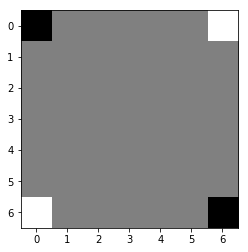

CPU times: user 104 µs, sys: 10 µs, total: 114 µs
Wall time: 41.2 µs
0


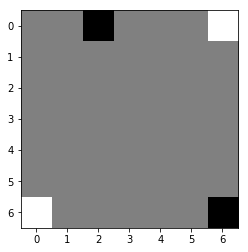

CPU times: user 122 µs, sys: 12 µs, total: 134 µs
Wall time: 48.2 µs
0


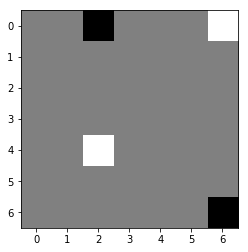

CPU times: user 120 µs, sys: 12 µs, total: 132 µs
Wall time: 47 µs
0


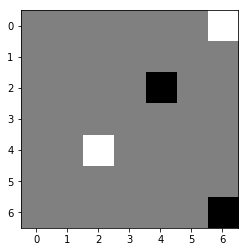

CPU times: user 149 µs, sys: 14 µs, total: 163 µs
Wall time: 57.9 µs
0


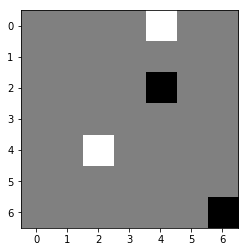

CPU times: user 129 µs, sys: 12 µs, total: 141 µs
Wall time: 50.3 µs
0


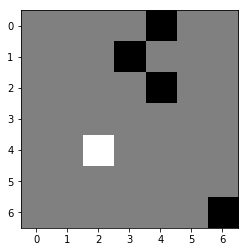

CPU times: user 120 µs, sys: 12 µs, total: 132 µs
Wall time: 46.5 µs
0


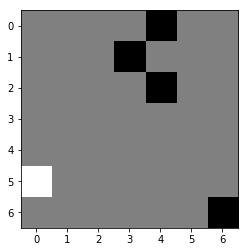

CPU times: user 143 µs, sys: 14 µs, total: 157 µs
Wall time: 55.6 µs
0


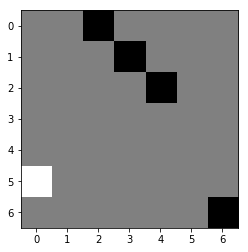

CPU times: user 109 µs, sys: 10 µs, total: 119 µs
Wall time: 42.7 µs
0


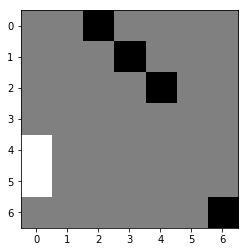

CPU times: user 145 µs, sys: 14 µs, total: 159 µs
Wall time: 56.7 µs
0


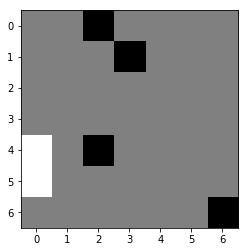

CPU times: user 137 µs, sys: 13 µs, total: 150 µs
Wall time: 53.2 µs
0


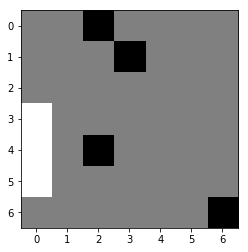

CPU times: user 136 µs, sys: 13 µs, total: 149 µs
Wall time: 53.2 µs
0


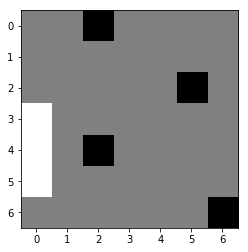

CPU times: user 110 µs, sys: 11 µs, total: 121 µs
Wall time: 64.6 µs
0


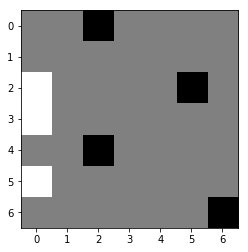

CPU times: user 183 µs, sys: 18 µs, total: 201 µs
Wall time: 71.8 µs
0


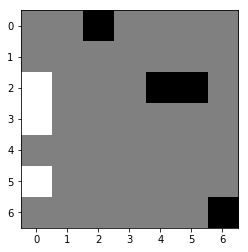

CPU times: user 0 ns, sys: 133 µs, total: 133 µs
Wall time: 47.2 µs
0


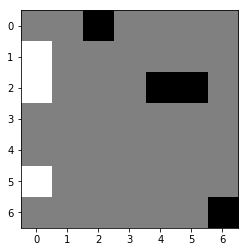

CPU times: user 158 µs, sys: 16 µs, total: 174 µs
Wall time: 61.3 µs
0


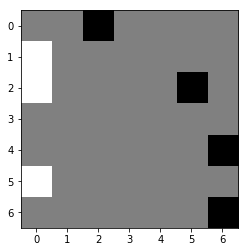

CPU times: user 118 µs, sys: 11 µs, total: 129 µs
Wall time: 46.3 µs
0


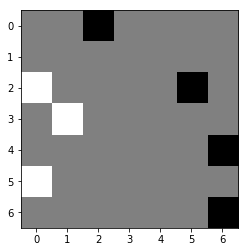

CPU times: user 139 µs, sys: 13 µs, total: 152 µs
Wall time: 54.1 µs
0


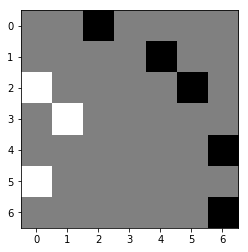

CPU times: user 126 µs, sys: 13 µs, total: 139 µs
Wall time: 49.6 µs
0


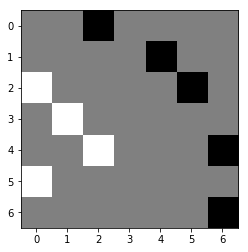

CPU times: user 140 µs, sys: 14 µs, total: 154 µs
Wall time: 54.4 µs
0


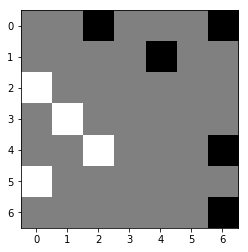

CPU times: user 144 µs, sys: 14 µs, total: 158 µs
Wall time: 55.8 µs
0


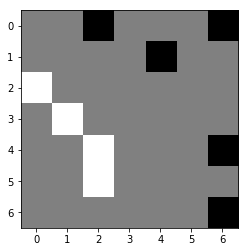

CPU times: user 151 µs, sys: 14 µs, total: 165 µs
Wall time: 58.2 µs
0


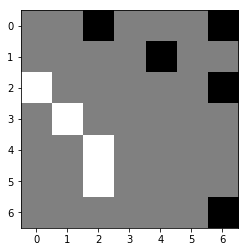

CPU times: user 178 µs, sys: 18 µs, total: 196 µs
Wall time: 68.7 µs
0


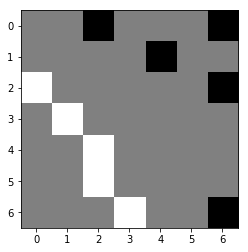

CPU times: user 140 µs, sys: 13 µs, total: 153 µs
Wall time: 54.6 µs
0


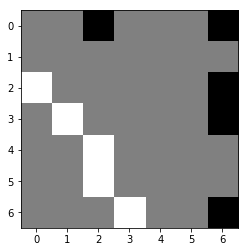

CPU times: user 156 µs, sys: 15 µs, total: 171 µs
Wall time: 60.3 µs
0


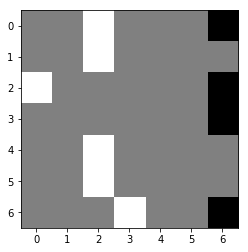

CPU times: user 144 µs, sys: 14 µs, total: 158 µs
Wall time: 56.3 µs
0


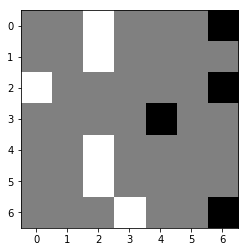

CPU times: user 152 µs, sys: 15 µs, total: 167 µs
Wall time: 59.1 µs
0


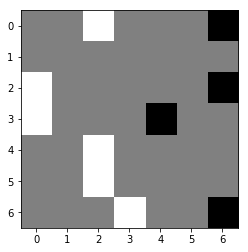

CPU times: user 139 µs, sys: 14 µs, total: 153 µs
Wall time: 53.6 µs
0


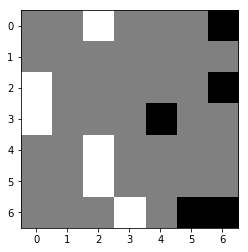

CPU times: user 160 µs, sys: 15 µs, total: 175 µs
Wall time: 61.5 µs
0


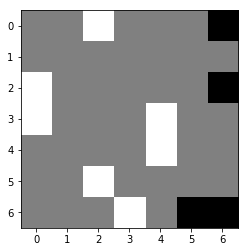

CPU times: user 132 µs, sys: 13 µs, total: 145 µs
Wall time: 51 µs
0


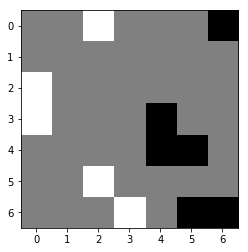

CPU times: user 145 µs, sys: 14 µs, total: 159 µs
Wall time: 56.5 µs
0


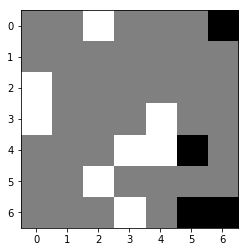

CPU times: user 117 µs, sys: 12 µs, total: 129 µs
Wall time: 46 µs
0


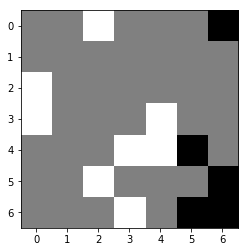

CPU times: user 186 µs, sys: 18 µs, total: 204 µs
Wall time: 71 µs
0


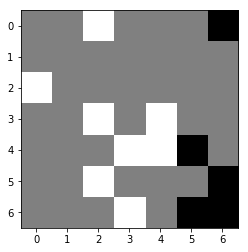

CPU times: user 130 µs, sys: 13 µs, total: 143 µs
Wall time: 50.1 µs
0


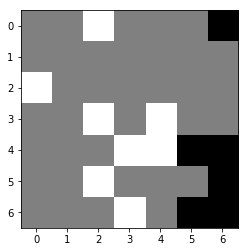

CPU times: user 170 µs, sys: 16 µs, total: 186 µs
Wall time: 65.8 µs
0


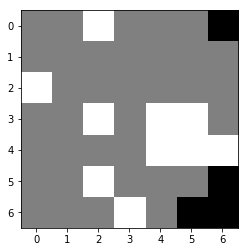

CPU times: user 113 µs, sys: 11 µs, total: 124 µs
Wall time: 44.3 µs
0


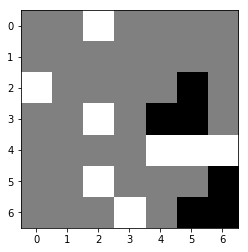

CPU times: user 150 µs, sys: 14 µs, total: 164 µs
Wall time: 57.9 µs
0


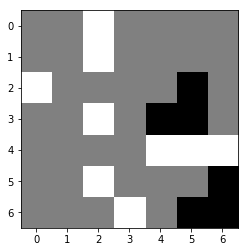

CPU times: user 149 µs, sys: 15 µs, total: 164 µs
Wall time: 57.7 µs
0


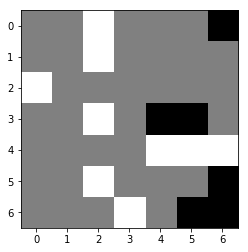

CPU times: user 0 ns, sys: 183 µs, total: 183 µs
Wall time: 64.1 µs
0


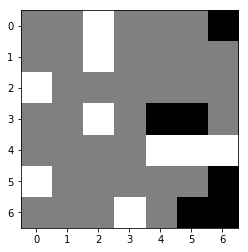

CPU times: user 140 µs, sys: 13 µs, total: 153 µs
Wall time: 54.1 µs
0


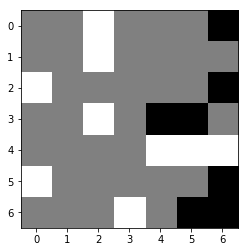

CPU times: user 207 µs, sys: 21 µs, total: 228 µs
Wall time: 79.4 µs
0


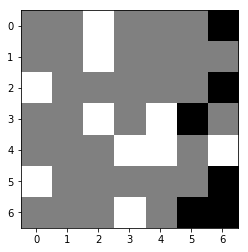

CPU times: user 0 ns, sys: 188 µs, total: 188 µs
Wall time: 66.5 µs
0


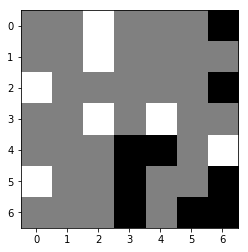

CPU times: user 141 µs, sys: 14 µs, total: 155 µs
Wall time: 54.6 µs
0


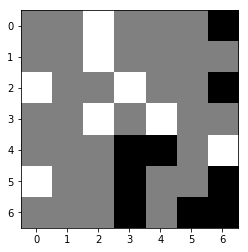

CPU times: user 146 µs, sys: 15 µs, total: 161 µs
Wall time: 56.7 µs
0


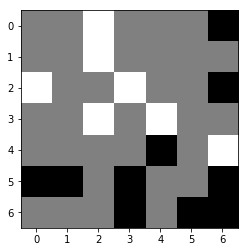

CPU times: user 167 µs, sys: 17 µs, total: 184 µs
Wall time: 64.4 µs
0


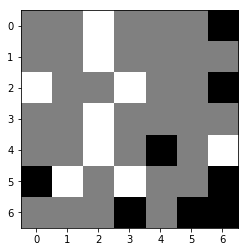

CPU times: user 151 µs, sys: 15 µs, total: 166 µs
Wall time: 58.7 µs
0


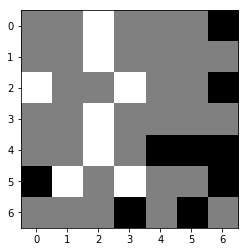

CPU times: user 182 µs, sys: 18 µs, total: 200 µs
Wall time: 69.9 µs
0


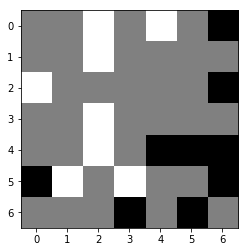

CPU times: user 151 µs, sys: 15 µs, total: 166 µs
Wall time: 58.2 µs
0


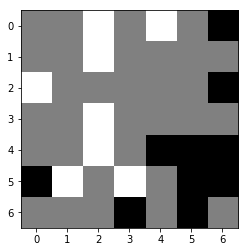

CPU times: user 235 µs, sys: 23 µs, total: 258 µs
Wall time: 90.4 µs
0


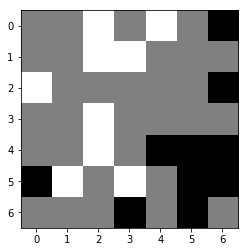

CPU times: user 202 µs, sys: 20 µs, total: 222 µs
Wall time: 78.2 µs
0


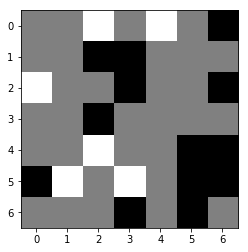

CPU times: user 161 µs, sys: 16 µs, total: 177 µs
Wall time: 63.2 µs
0


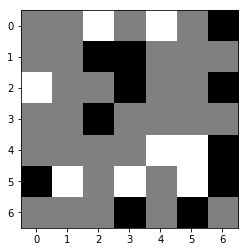

CPU times: user 181 µs, sys: 18 µs, total: 199 µs
Wall time: 70.1 µs
0


KeyboardInterrupt: 

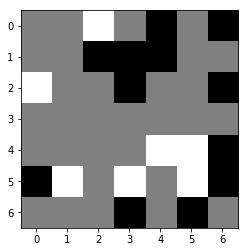

In [455]:
game = Ataxx()
turn = -1
while abs(game.evaluate(1, turn)) != 1:
    print(game.evaluate(1, turn))
    game.plot()
    %time next_moves = [i for i in game.get_moves(turn)]

    best_move = choice(next_moves)
        
    game.move_to(turn, best_move[0], best_move[1])
    turn = -turn
    time.sleep(0.1)

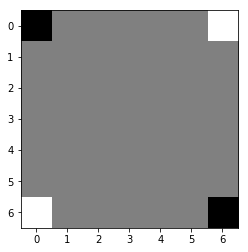

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
176


In [224]:
player = MCTS(1)
player._game.plot()
steps = 0
while abs(player._game.evaluate(1, player._turn)) != 1:
    print(player._game.evaluate(1, player._turn))
    if player._turn:
        print("random turn")
        best_move = choice(player._game.get_moves(player._turn))
    else:
        print("mcts' turn")
        %time best_move = player.get_next_move(1000)
    steps += 1
        
    player.make_a_move(best_move)
    #player._game.plot()
    #time.sleep(0.1)
print(steps)

In [137]:
game = Ataxx()
def run(game):
    turn = -1
    for i in range(100000):
        best_move = choice(game.get_moves(turn))
%lprun -f game.get_moves run(game)

In [369]:
import numba as nb
spec = [
    ('data', nb.int8[:, :]),               # a simple scalar field
]

#@nb.jitclass(spec)
class Ataxx0:
    def policy_array_generator(self):
        policy_list = []
        for r in range(7):
            for c in range(7):
                for dr in range(-2, 3):
                    for dc in range(-2, 3):
                        new_r = r + dr
                        new_c = c + dc
                        if (dr != 0 or dc != 0) and (new_r < 7 and new_r >= 0) and (new_c < 7 and new_c >= 0):
                            policy_list.append([r, c, new_r, new_c])
                                
        return np.array(policy_list, dtype=np.int8)

    def __init__(self, board=None):
        if board is None:                  # if there is no initialization given
            self.data = np.zeros((7, 7), dtype=np.int8)   # then generate a board with starting init, and black(-1) takes first turn
            self.data[0, 0] = -1           
            self.data[6, 6] = -1
            self.data[0, 6] = 1
            self.data[6, 0] = 1
        else:
            self.data = board.copy()
    
    def plot(self, is_next_move=False, turn=None):                        # plot the board
        image = self.data.copy()
        if is_next_move:
            if turn not in [-1, 1]:
                raise ValueError("Turn must be -1 or 1, or Must input a turn for next moves")
            else:
                next_moves = self.get_moves(turn)
                if len(next_moves) == 0:
                    raise ValueError("Game is over already")
                next_pos = list(zip(*next_moves))[1]
                for pos in next_pos:
                    image[pos] = turn / 2
        plt.imshow(image, cmap='gray')
        plt.xticks(range(7), range(7))
        plt.yticks(range(7), range(7))
        plt.show()
                
    def is_valid(self, turn, pos):
        r = pos[0]
        c = pos[1]
        if self.data[r, c] != 0:
            return False
        else:
            for dr in range(-2, 3):
                for dc in range(-2, 3):
                    new_r = r+dr
                    new_c = c+dc
                    if new_r >= 0 and new_c >= 0 and new_r < 7 and new_c < 7 and self.data[new_r, new_c] == turn:
                        return True
            return False 
    
    @nb.jit(nopython=True)
    def get_moves(self, turn):
        #cdef bool has_duplicate_move
        next_moves = []
        for r in range(7):
            for c in range(7):
                has_duplicate_move = False      # move within the radius of one of another friendly piece is called
                if self.is_valid(turn, (r, c)): # duplicate move
                    for dr in range(-2, 3):
                        for dc in range(-2, 3):
                            new_r = r+dr
                            new_c = c+dc
                            if new_r >= 0 and new_c >= 0 and new_r < 7 and new_c < 7:
                                if abs(dr) <= 1 and abs(dc) <=1:
                                    if has_duplicate_move: 
                                        continue        # no need to record same move again
                                    elif self.data[new_r, new_c] == turn:
                                        next_moves.append(((new_r, new_c), (r, c)))
                                        has_duplicate_move = True
                                elif self.data[new_r, new_c] == turn:
                                    next_moves.append(((new_r, new_c), (r, c)))
                                else:
                                    continue
        return next_moves
    
    def get_greedy_move(self, turn):
        moves = self.get_moves(turn)
        if len(moves) == 0:
            raise ValueError('No Possible Moves')
        store_data = self.data.copy()
        best_score = -1000000
        for move in moves:
            self.data = store_data.copy()
            self.move_to(turn, move[0], move[1])
            score = self.evaluate(turn, -turn)
            if score > best_score:
                best_move = move
                best_score = score
        self.data = store_data
        return best_move
        
    def move_to(self, turn, pos0, pos1):
        x0 = pos0[0]
        y0 = pos0[1]
        x1 = pos1[0]
        y1 = pos1[1]
        
        if not self.is_valid(turn, pos1):
            raise ValueError("This move: " + str((pos0, pos1)) + " of turn: " + str(turn) + " is invalid") 
        elif self.data[x0, y0] != turn:
            raise ValueError("The starting position is not your piece")
        else:
            self.data[x1, y1] = turn
            if abs(x0 - x1) > 1 or abs(y0 - y1) > 1:   # jump move
                self.data[x0, y0] = 0

            for dr in range(-1, 2):                  # infection mode!!!!
                for dc in range(-1, 2):
                    if x1+dr >= 0 and y1+dc >= 0 and x1+dr < 7 and y1+dc < 7:
                        if self.data[x1+dr, y1+dc] == -turn:  # convert any piece of the opponent to 'turn'
                            self.data[x1+dr, y1+dc] = turn
    
    def evaluate(self, turn, this_turn, max_score=1, min_score=0):
        turn_no = 0
        op_no = 0
        for r in range(7):
            for c in range(7):
                if self.data[r, c] == turn:
                    turn_no += 1
                elif self.data[r, c] == -turn:
                    op_no += 1
        if len(self.get_moves(this_turn)) == 0:# if one of them can no longer move, count and end
            if turn_no > op_no:
                return max_score
            else:
                return -max_score
        else:
            value = turn_no - op_no
        return value * min_score